In [ ]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
import numpy as np
import time


In [ ]:
TRAIN_PATH = '/content/drive/MyDrive/rabbits/train'
TEST_PATH = '/content/drive/MyDrive/rabbits/test'
VAL_PATH = '/content/drive/MyDrive/rabbits/valid'

In [ ]:
cv2.setUseOptimized(True)
cv2.setNumThreads(4)

In [ ]:
def get_image(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    return image.numpy()


def get_labels(path):
    df = pd.read_csv(os.path.join(path, '_annotations.csv'))
    labels = []
    images = []
    names = []
    
    for i in range(df.shape[0]):
        line = df.iloc[i].to_numpy()
        if line[0] in names:
            labels[-1].append(line[-4:])
            continue
        labels.append([line[-4:]])
        images.append(get_image(os.path.join(path, line[0])))
        names.append(line[0])

    images = np.array(images)
    images = images / 255
    return images.astype(np.float32), labels


def unison_shuffled_copies(list_a, list_b):
    random_permutation = np.random.permutation(len(list_a))
    return list_a[random_permutation], list_b[random_permutation]


def iou(box1, box2):
    # box1 contains [min_x, min_y, height, width]
    # box2 contains [min_x, min_y, height, width]

    xmin = max(box1[1], box2[1])
    ymin = max(box1[0], box2[0])
    xmax = min(box1[3] + box1[1], box2[3] + box2[1])
    ymax = min(box1[2] + box1[0], box2[2] + box2[0])
    
    intersection = (xmax - xmin) * (ymax - ymin)
    union = box1[3] * box1[2] + box2[3] * box2[2] - intersection
    return max(0, intersection / union)


def nonmax(boxes, scores, thresh=0.5):
    boxes_out = []
    scores_out = []
    append_lst = np.ones((len(boxes),))
    
    for i, box in enumerate(boxes):
        if i - 1 == len(boxes):
            break
        for j, other_box in enumerate(boxes[i + 1:]):
            if append_lst[i + j + 1] == 0:
                continue
            if iou(box, other_box) > thresh:
                if scores[i] < scores[i + j + 1]:
                    append_lst[i] = 0
                    break
                else:
                    append_lst[i + j + 1] = 0
                    
    
    for num, i in enumerate(append_lst):
        if i:
            boxes_out.append(boxes[num])
            scores_out.append(scores[num])
    
    boxes_out, scores_out = np.array(boxes_out), np.array(scores_out)

    return boxes_out, scores_out


def get_proper_sets(x, y, target_shape=(224, 224)):
    negative_set = []
    positive_set = []
    max_height, max_width = x.shape[1:3]

    for counter, image in enumerate(x):
        boxes = y[counter]
        
        width = np.random.randint(50, target_shape[1])
        height = np.random.randint(50, target_shape[0])
        
        end_status = False
        for j in range(20):
            ix = np.random.randint(0, max_width - width)
            iy = np.random.randint(0, max_height - height)
            
            for num, box in enumerate(boxes):
                if iou(box, [iy, ix, height, width]) < 0.2:
                    if num == len(boxes) - 1:
                        end_status = True
                else:
                    break
            
            if end_status:
                break
        
        if not end_status:
            continue

        matr = image[iy:iy+height, ix:ix+width]
        negative_set.append(tf.image.resize(matr, target_shape).numpy())

        box = boxes[0]
        rect = image[box[1]:box[3], box[0]:box[2]]
        rect = tf.image.resize(rect, target_shape).numpy()
        positive_set.append(rect)
    
    positive_set, negative_set = np.array(positive_set), np.array(negative_set)

    set_x = np.vstack((positive_set, negative_set))
    set_y = np.concatenate([np.ones((positive_set.shape[0],)), np.zeros((negative_set.shape[0],))])
    set_x, set_y = unison_shuffled_copies(set_x, set_y)

    return set_x, set_y


def get_images_full(images, labels, model, input_shape=(224, 224), num_proc_rects=100, mode='fast', threshold=0.5):
    all_rects = []
    time_search_rects, time_predict_rects = [], []
    for image, label in zip(images, labels):
        image_out = image.copy()
        indexes, rects_prep = [], []

        start = time.time()
        selective_search = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

        selective_search.setBaseImage(image)

        if mode == 'fast':
            selective_search.switchToSelectiveSearchFast()
        else:
            selective_search.switchToSelectiveSearchQuality()
        
        rects = selective_search.process()
        time_search_rects.append(time.time() - start)

        if not num_proc_rects:
            num_proc_rects = len(rects)

        for i, rect in enumerate(rects):
            if (i < num_proc_rects):
                x, y, w, h = rect
                if w * h / image.shape[0] ** 2 < 0.05:
                    continue
                rects_prep.append(tf.image.resize(image_out[y:y+h, x:x+w], input_shape).numpy())
                indexes.append(i)


        rects_prep = np.array(rects_prep)

        start = time.time()
        scores = model.predict(rects_prep).reshape(-1,)
        time_predict_rects.append(time.time() - start)


        rects = rects[indexes]
        rects = rects[np.where(scores > threshold)]
        scores = scores[np.where(scores > threshold)]
        
        if len(rects) > 1:
            rects, scores = nonmax(rects, scores)
        
        all_rects.append(rects)
    
    return all_rects, time_search_rects, time_predict_rects


def find_precision_and_recall(y_true, y_pred):
    if len(y_pred) == 0:
        return 0, 0
    true_pos, false_pos, false_neg = 0, 0, 0
    results = np.zeros((len(y_true), len(y_pred)))
    
    for i, box_pred in enumerate(y_pred):
        for j, box_true in enumerate(y_true):
            box_true = [box_true[0], box_true[1], box_true[2] - box_true[0], box_true[3] - box_true[1]]
            if iou(box_pred, box_true) > 0.5:
                results[j, i] = 1

    true_pos = np.sum(results)
    false_negative = len(y_true) - np.sum(np.max(results, axis=1))
    false_positive = len(y_pred) - np.sum(np.max(results, axis=0))
    
    precision = true_pos / (true_pos + false_positive)
    recall = true_pos / (true_pos + false_negative)
    return precision, recall

In [ ]:
# train_x, train_y = get_labels(TRAIN_PATH)
# val_x, val_y = get_labels(VAL_PATH)
test_x, test_y = get_labels(TEST_PATH)

# proper_train_x, proper_train_y = get_proper_sets(train_x, train_y)
# proper_val_x, proper_val_y = get_proper_sets(val_x, val_y)
# proper_test_x, proper_test_y = get_proper_sets(test_x, test_y)

model_vgg = tf.keras.models.load_model('/content/drive/MyDrive/model_vgg_1.h5')

In [ ]:
rects, time_search_rects, time_predict_rects = get_images_full(test_x, test_y, model_vgg, mode='quality', num_proc_rects=300)

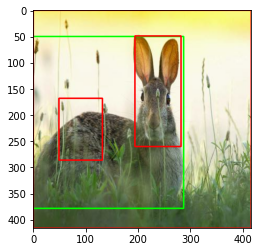

Precision = 0.3333333333333333, recall = 1.0


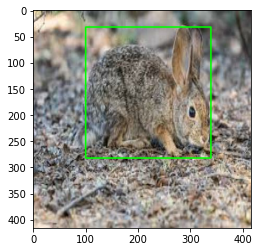

Precision = 0, recall = 0


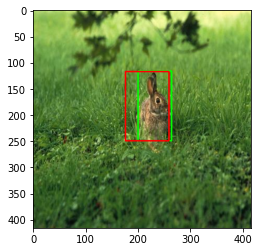

Precision = 1.0, recall = 1.0


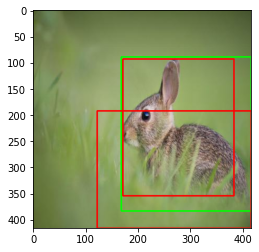

Precision = 1.0, recall = 1.0


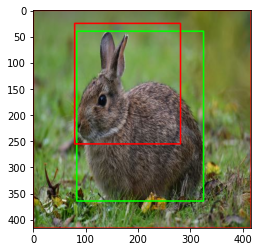

Precision = 0.5, recall = 1.0


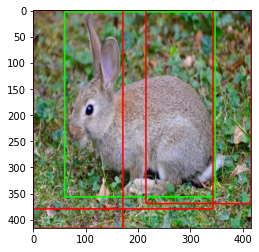

Precision = 0.3333333333333333, recall = 1.0


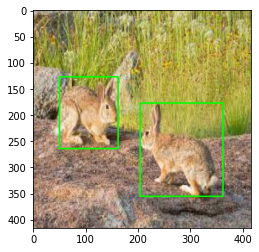

Precision = 0, recall = 0


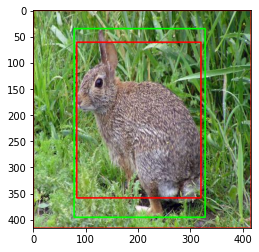

Precision = 1.0, recall = 1.0


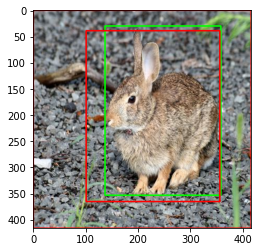

Precision = 0.5, recall = 1.0


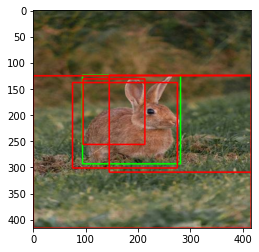

Precision = 0.25, recall = 1.0


In [ ]:
prec, rec = [], []
for image, boxes_true, boxes_pred in zip(test_x.copy(), test_y, rects):
    for true_box in boxes_true:
        xmin, ymin, xmax, ymax = true_box
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 1, 0), 2, cv2.LINE_AA)
    
    for pred_box in boxes_pred:
        x, y, w, h = pred_box
        cv2.rectangle(image, (x, y), (x+w, y+h), (1, 0, 0), 2, cv2.LINE_AA)
    plt.imshow(image)
    plt.show()
    precision, recall = find_precision_and_recall(boxes_true, boxes_pred)
    prec.append(precision)
    rec.append(recall)
    print(f'Precision = {precision}, recall = {recall}')

In [ ]:
# My results

# With default values it took
# (1) - to find all rectangels: 2.42s
# (2) - to preprocces (num_proc_rects) of them: 0.017s
# (3) - to predict values: 9.44s
# (4) - to nonmax boxes: 1e-4s
# (5) - to calculate precision and recall: 1e-4s
# (Sum): 11.88s for 1 image 
# Average precision (AP): (varies) 0.6
# Average recall(AR): 0.6

# short format
# (1) (2) (3) (4) (5)
# (Sum)
# (AP) (AR)

# default values, CPU
# 2.42 0.017 9.44 0.0001 0.0001
# 11.88
# 0.6 0.6

# mode = 'fast', num_proc_rects = 300, CPU
# 2.447312927246094 0.04978315830230713 29.726715278625488 0.00035789012908935545 0.00013918876647949218
# 32.22430844306946
# 0.625 0.9

# mode = 'quality', CPU
# 7.51388795375824 0.01994650363922119 11.476025557518005 0.00022068023681640626 0.00015439987182617188
# 19.010235095024107
# 0.7333333333333333 1.0

# mode = 'quality', num_proc_rects = 300, CPU
# 7.525289750099182 0.05374524593353271 31.12360301017761 0.00046751499176025393 0.0001287221908569336
# 38.70323424339294
# 0.7 0.9

# mode = 'quality', num_proc_rects = 0 (all), CPU
# 7.580562090873718 0.35656726360321045 193.16282052993773 0.010767984390258788 0.00016295909881591797
# 201.11088082790374
# 0.7033333333333334 1.0

# Since (2) + (4) + (5) < (Sum) * 0.01, i won't count them anymore

# default values, GPU
# 1.7554206848144531 0.017616653442382814 2.215176796913147 9.758472442626953e-05 0.00010950565338134766
# 3.988421225547791
# 0.6833333333333333 0.8

# mode = 'fast', num_proc_rects = 300, GPU
# 1.7333752632141113 1.5227652788162231
# 3.2561405420303347
# 0.4333333333333333 0.8

# mode = 'fast', num_proc_rects = 0 (all), GPU
# 1.7079659938812255 1.4973726511001586
# 3.205338644981384
# 0.39499999999999996 0.8

# mode = 'quality', num_proc_rects = 300, GPU
# 5.728960084915161 6.640197515487671
# 12.369157600402833
# 0.45 0.7

# mode = 'quality', num_proc_rects = 0 (all), GPU
# 5.7120441675186155 2.5990633726119996
# 8.311107540130616
# 0.5702380952380952 0.8


# Also, i've tried to resize image before searching boxes to save some time
# It took 0.31s to get all 35 proposals, after resizing original shape from (416, 416) to (104, 104) 
# It took 1.29s to get all 119 proposals, after resizing original shape from (416, 416) to (208, 208) 
# It took 5.35s to get all 453 proposals, without resizing
# As we can see, decreasing overall size in k times decreases time needed in k times and amount of proposals in k times

# mode = 'quality', num_proc_rects = 0 (all), images were resized to (208, 208), GPU
# 1.3753852128982544 1.400636577606201
# 2.7760217905044557
# 0.47333333333333333 0.9